In [20]:
import pandas as pd
import numpy as np
import os
import yfinance as yf
import itertools
import warnings
import functions as func
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import shapiro

from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates


In [2]:
DATA_PATH = "nvda_data.json"

if os.path.exists(DATA_PATH):
    
    with open(DATA_PATH) as f:
        nvda_hist = pd.read_json(DATA_PATH)
else:
    nvda = yf.Ticker("NVDA")
    nvda_hist = nvda.history(period="max")

    nvda_hist.to_json(DATA_PATH)

In [10]:
df_nvda = func.calculate_technical_indicators(nvda_hist)
df_nvda.index = pd.to_datetime(df_nvda.index)
start_date = pd.Timestamp('2020-01-22 05:00:00')
df_nvda = df_nvda[df_nvda.index >= start_date]
df_nvda

Open        High         Low       Close    Volume  \
2020-01-22 05:00:00   62.194028   63.147757   62.004778   62.281185  23924000   
2020-01-23 05:00:00   62.682103   63.050645   61.793117   62.965981  24451600   
2020-01-24 05:00:00   64.121417   64.619447   61.830478   62.373329  37351200   
2020-01-27 05:00:00   59.325386   60.323936   57.828802   59.813454  47053600   
2020-01-28 05:00:00   60.473346   62.072023   59.940453   61.748302  31097600   
...                         ...         ...         ...         ...       ...   
2024-04-03 04:00:00  884.840027  903.739990  884.000000  889.640015  37006700   
2024-04-04 04:00:00  904.059998  906.340027  858.799988  859.049988  43496500   
2024-04-05 04:00:00  868.659973  884.809998  859.260010  880.080017  39885700   
2024-04-08 04:00:00  887.000000  888.299988  867.320007  871.330017  28322000   
2024-04-09 04:00:00  874.419983  876.349976  830.219971  853.539978  50170000   

                     Dividends  Stock Splits      ema_12      ema_26  \
2020-01-22 05:00:00        0.0           0.0   61.130378   59.422451   
2020-01-23 05:00:00        0.0           0.0   61.412779   59.684935   
2020-01-24 05:00:00        0.0           0.0   61.560556   59.884075   
2020-01-27 05:00:00        0.0           0.0   61.291771   59.878844   
2020-01-28 05:00:00        0.0           0.0   61.362006   60.017322   
...                        ...           ...         ...         ...   
2024-04-03 04:00:00        0.0           0.0  900.472060  867.487024   
2024-04-04 04:00:00        0.0           0.0  894.099433  866.862058   
2024-04-05 04:00:00        0.0           0.0  891.942600  867.841166   
2024-04-08 04:00:00        0.0           0.0  888.771433  868.099600   
2024-04-09 04:00:00        0.0           0.0  883.351209  867.021109   

                     macd_line  macd_signal        rsi  
2020-01-22 05:00:00   1.707928     1.752482  69.491936  
2020-01-23 05:00:00   1.727844     1.747554  67.921355  
2020-01-24 05:00:00   1.676481     1.733340  70.781688  
2020-01-27 05:00:00   1.412927     1.669257  53.571394  
2020-01-28 05:00:00   1.344684     1.604342  58.227600  
...                        ...          ...        ...  
2024-04-03 04:00:00  32.985035    43.675697  44.162626  
2024-04-04 04:00:00  27.237375    40.388032  43.856582  
2024-04-05 04:00:00  24.101433    37.130712  50.459906  
2024-04-08 04:00:00  20.671833    33.838937  46.493006  
2024-04-09 04:00:00  16.330100    30.337169  39.727705  

[1061 rows x 12 columns]

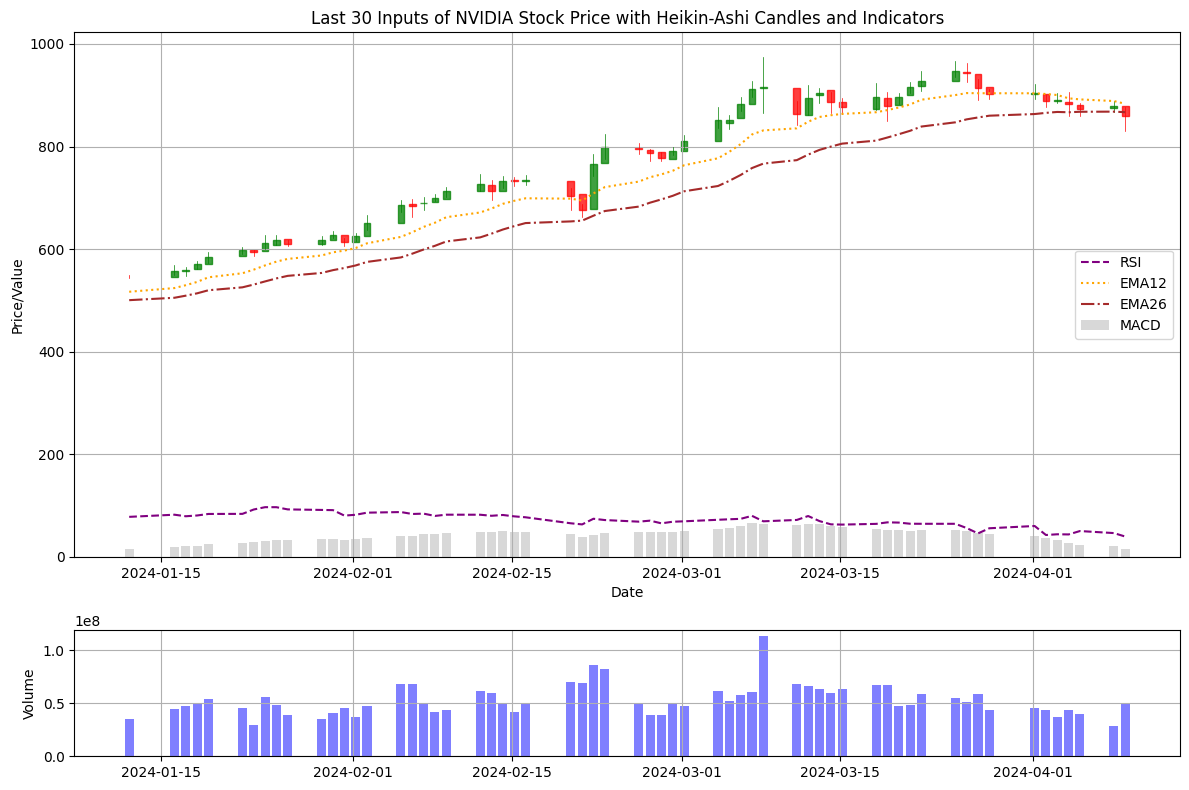

In [26]:
df_nvda.index = pd.to_datetime(df_nvda.index)

df_last_30 = df_nvda.tail(60)

ha_close = (df_last_30['Open'] + df_last_30['High'] + df_last_30['Low'] + df_last_30['Close']) / 4
ha_open = (df_last_30['Open'].shift(1) + df_last_30['Close'].shift(1)) / 2
ha_high = df_last_30[['High', 'Open', 'Close']].max(axis=1)
ha_low = df_last_30[['Low', 'Open', 'Close']].min(axis=1)


df_ha = pd.DataFrame({'Date': df_last_30.index,
                      'Open': ha_open,
                      'High': ha_high,
                      'Low': ha_low,
                      'Close': ha_close})


plt.figure(figsize=(12, 8))


ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
ax1.xaxis_date()
ax1.grid(True) 


df_ha['Date'] = df_ha['Date'].apply(mdates.date2num)

candlestick_ohlc(ax1, df_ha.values, width=0.6, colorup='green', colordown='red', alpha=0.75)

plt.plot(df_last_30.index, df_last_30['rsi'].tail(60), label='RSI', color='purple', linestyle='dashed')
plt.plot(df_last_30.index, df_last_30['ema_12'].tail(60), label='EMA12', color='orange', linestyle='dotted')
plt.plot(df_last_30.index, df_last_30['ema_26'].tail(60), label='EMA26', color='brown', linestyle='dashdot')
plt.bar(df_last_30.index, df_last_30['macd_line'].tail(60), label='MACD', color='gray', alpha=0.3)

plt.title('Last 30 Inputs of NVIDIA Stock Price with Heikin-Ashi Candles and Indicators')
plt.xlabel('Date')
plt.ylabel('Price/Value')
plt.legend()

ax2 = plt.subplot2grid((4, 1), (3, 0), sharex=ax1, rowspan=1)
ax2.bar(df_last_30.index, df_last_30['Volume'].tail(60), color='blue', alpha=0.5)
ax2.grid(True)
plt.ylabel('Volume') 

plt.tight_layout()

plt.show()